
# MMF1921/MIE377 Style Backtesting Template

From the MIE377/MMF1921 Projects:

        The purpose of this program is to provide a template with which to develop Project 2. The project requires you to test different models  (and/or different model combinations) to create an asset management algorithm.

        This template will be used by the instructor and TA to assess your trading algorithm using different datasets.

        # PLEASE DO NOT MODIFY THIS TEMPLATE (for Project submission purposes)

This template for evaluating asset allocation algorithms is the exact same style as the one in MIE377.

Is it fast? No it is not.

Is it clear and relatively easy to follow? Yes it is.

There are a couple of moving parts:

* The database: see the Database folder for examples of where and how the data was processed. Download SQLLite viewer to explore the data and look at the queries in the notebooks to understand what data is in there
* The services: in the services folder there are some helpers to extract the data (data_retrieval.py), estimate means and covariances (estimators.py), and optimizers (optimization.py)
* Strategies are also defined in the services folder. The current convention is that a strategy takes in data (returns and factor returns) and outputs an allocation.
* Typically, the strategies will use some form of estimator and an optimizer come up with allocations.

If you do not want to deal with the database then use the MIE377_Project_Main template and copy cells 2.1 and 2.2 into the appropriate spot
and replace 

        x[:,t] = project_function(periodReturns, periodFactRet)

with

        x[:,t] = Strategy.execute_strategy(periodReturns, periodFactRet) #equal_weight(periodReturns) #StrategyFunction(periodReturns, periodFactRet, x0[:,t]);

# 1. Read input files

In [108]:
import time
import math

import numpy as np
import pandas as pd

from Database.services.database import Database
from sqlalchemy import inspect
from services.data_retreival import *
from scipy.stats import gmean
import matplotlib.pyplot as plt
from services.strategies import *
from services.optimization_layers import *
from services.optimization import *
from services.binary_optimization import *
from services.environment_functions import *
from services.big_m_strategies import *

Database.initialize("sqlite:///Database//financial_db.sqlite") #for courses replace this with a flat file
inspector = inspect(Database.engine)
print(inspector.get_table_names())

universe = 'SP'
imputation_method = 'Multivariate'
ticker_str = 'AAPL'
#exponential params


adjClose = pd.read_csv("flat_files/MonthlyAssetPrices"+ universe + ".csv", index_col=0, header = 1).iloc[1:,:]

daily_adjClose =  pd.read_csv("flat_files/DailyAssetPrices"+universe + ".csv", index_col=0, header = 1).iloc[1:,:]

TechnicalAnalysis = pd.read_csv("flat_files/TechnicalAnalysis" + universe + ".csv", index_col=[0,1])

if universe ==  'SP':
    FinancialRatios = pd.read_csv("flat_files/" + imputation_method + "WRDS.csv", index_col=[0,1])
    TechnicalAnalysis.index.names = FinancialRatios.index.names
    ContextualInfo = TechnicalAnalysis.merge(FinancialRatios, how = 'left', left_index=True, right_index=True)

else:
    TechnicalAnalysis.index.names = ['date', 'ticker']
    ContextualInfo = TechnicalAnalysis


['asset_id', 'currency_id', 'equities_series', 'equity_index_id', 'exchange_id', 'factor_id', 'factors', 'frequency_id', 'fundamentals', 'metric_id', 'source_id', 'ticker_id', 'ticker_index_membership', 'tiingo_tickers']


In [109]:
adjClose.index = pd.to_datetime(adjClose.index, format='%Y-%m-%d').tz_localize(None)
daily_adjClose.index = pd.to_datetime(daily_adjClose.index, format='%Y-%m-%d').tz_localize(None)
ContextualInfo.index = ContextualInfo.index.set_levels([pd.to_datetime(ContextualInfo.index.levels[0]).tz_localize(None), ContextualInfo.index.levels[1]])

In [110]:
print("The earliest possible start date")
max(daily_adjClose.index.unique()[0], ContextualInfo.index.get_level_values('date').unique()[0], adjClose.index.unique()[0])

The earliest possible start date


Timestamp('1996-11-30 00:00:00')

In [111]:
print("The latest possible start date")
min(daily_adjClose.index.unique()[-1], ContextualInfo.index.get_level_values('date').unique()[-1], adjClose.index.unique()[-1])

The latest possible start date


Timestamp('2023-04-21 00:00:00')

In [112]:
start_date = pd.to_datetime('1996-11-30', format = '%Y-%m-%d')

end_date = pd.to_datetime('2022-12-31', format = '%Y-%m-%d')

# start_date = pd.to_datetime('2006-05-31', format = '%Y-%m-%d')
#
# end_date = pd.to_datetime('2022-12-31', format = '%Y-%m-%d')

factors = ('Mkt-RF', 'RF')

factorRet = get_monthly_factors(factors, start_date, end_date, Database)

factorRet = factorRet.droplevel(0, axis = 1)
factorRet.columns = [col.strip() for col in factorRet.columns]

In [113]:
adjClose = adjClose[start_date:end_date]
daily_adjClose = daily_adjClose[start_date:end_date]
idx = pd.IndexSlice
ContextualInfo = ContextualInfo.loc[idx[start_date:end_date, :], :]

In [114]:
# Initial budget to invest ($100,000)
initialVal = 100000

# Length of investment period (in months) - but actually units of data
investPeriod = 6

# divide the factor returns by 100
factorRet = factorRet/100

#rf and factor returns
#drop the first observation to align the dataset with the returns data that will
#result
factorRet = factorRet.iloc[1:, :]

#rf and factor returns
riskFree = factorRet['RF']
factorRet = factorRet.loc[:,factorRet.columns != 'RF'];

In [115]:
#Identify the tickers and the dates
tickers = adjClose.columns
dates   = factorRet.index

In [116]:
# Calculate the stocks monthly excess returns
# pct change and drop the first null observation
returns = adjClose.pct_change(1).iloc[1:, :]
returns = returns  - np.diag(riskFree.values) @ np.ones_like(returns.values) # risk adjusted returns
# Align the price table to the asset and factor returns tables by discarding the first observation.
adjClose = adjClose.iloc[1:,:]

In [117]:
assert adjClose.index[0] == returns.index[0]
assert adjClose.index[0] == factorRet.index[0]

# 2. Run your program

This section will run your Project1_Function in a loop. The data will be loaded progressively as a growing window of historical observations.
Rebalancing will take place after every loop

### 2.1 Some Standard Allocation Strategies

In [407]:
# Some strategies (uncomment this or the next cell to pick a strategy to test)
# Strategy = general_strategy(sample_estimator, MVO, NumObs=48)  #the general strategy object takes an estimator function and an optimizer function
#                                                                #the only constraint is that the estimators outputs are the optimizers inputs
# investor preferences (static throughout the backtest)
hyperparam_search = True # True if model has hyperparams
optimizer = SVMMVO # CardMVO , MVO
estimator = exponential_weighted_estimator

k = 6*20 #estimation horizon
alpha= 1 - 0.985 #estimation decay
return_premium = 1.4 #optimization premium

turnover_constraints = True
turnover_limit = 0.75 # 0.75, 1, 1.25
cardinality_ratio = 0.1 #optimization

MipGap = 0.05 # for portfolio optimizer
limit_time = 10 # for portfolio optimizer

target_return_strategy = premium_target # for portfolio optimizer to calculate return target
# mean_target, premium_target, ticker_return_target
target_return_strategy_args = ['premium'] # args for the return strategy

bigMStrategy = objectiveBigMStrategy #objectiveBigMStrategyTightening , objectiveBigMStrategy

bigM_limit_time=5 # for the feasible solution used to calculate big M
bigM_MipGap=0.1 # for the feasible solution used to calculate big M
bigM_SolutionLimit=10 # for the feasible solution used to calculate big <

SkipSOCP = True # flag to skip the SOCP
tightening_iter_lim = 1 # number of iterations of tightening to do

SVMMVO_bigM_time_limit = 5 # for computing a better solution in the tightening strategy
SVMMVO_MipGap=0.1 # for computing a better solution in the tightening strategy
SVMMVO_SolutionLimit=5 # for computing a better solution in the tightening strategy

SOCP_limit_time=10 # time limit for the SOCP's

ticker_index = tickers.get_loc(ticker_str) # the ticker we want to compare to if
#  we are using the ticker_return_target strategy

q = 10 #subset of features

C = 0.1 # separation importance
epsilon = 0.1 # regularization amount for SVM

separable = False # do not restrict the hyperplane to be separable

LogToConsole = False # display optimization results in the console
Verbose = True # print statements

hyperparams = {'C': list(np.geomspace(0.1, 100, 4)), 'epsilon': list(np.geomspace(0.1, 100, 4))} # hyperparams for hyperparam search
#q_alpha = 0.3187 # alpha for Q(t, a) = (1 - q_alpha) Q(t-1. a) + R(t, a)
q_alpha = 0.6838

investor_preferences = {'k':k, # horizon
                        'alpha':alpha, # decay
                        'premium':return_premium, # return premium preference
                        'ticker_index':ticker_index, # benchmark index for comparison used in place of return premium depending on the investors function to set r_min
                        'target_return_strategy':target_return_strategy, # strategy for setting return
                        'target_return_strategy_args': target_return_strategy_args, # args for return setting strategy
                        'turnover_limit':turnover_limit, # turnover limit
                        'turnover_constraints':turnover_constraints, # turnover limit choice (Y/N)
                        'cardinality_ratio': cardinality_ratio, # Pct of assets to invest in
                        'MipGap' : MipGap, 'limit_time':limit_time, # problem solving limits
    
                        'bigMStrategy':bigMStrategy,
                        'bigM_limit_time':bigM_limit_time,
                        'bigM_MipGap':bigM_MipGap,
                        'bigM_SolutionLimit':bigM_SolutionLimit,

                        'SkipSOCP':SkipSOCP,
                        'tightening_iter_lim':tightening_iter_lim,

                        'SVMMVO_bigM_time_limit':SVMMVO_bigM_time_limit,
                        'SVMMVO_MipGap':SVMMVO_MipGap,
                        'SVMMVO_SolutionLimit':SVMMVO_SolutionLimit,

                        'SOCP_limit_time':SOCP_limit_time,
                        'q':q,
                        'C':C,
                        'epsilon':epsilon,
                        'separable':separable,
                        'LogToConsole':LogToConsole,
                        'Verbose':Verbose,
                        'hyperparams':hyperparams,
                        'q_alpha':q_alpha}

Strategy = general_strategy(estimator, optimizer,
                            investor_preferences = investor_preferences)

Strategy.extract_estimation_info = populate_exponential_weighted_estimator
Strategy.extract_optimization_info = populate_kwargs

env = environment()
# see strategy script for different options OLS_RP() #OLS_MVO() #HistoricalMeanVarianceOptimization()

In [408]:

# Start of out-of-sample test period
testStart = returns.index[0] + pd.offsets.DateOffset(years=2)

# End of the first investment period
# testEnd = testStart + pd.offsets.DateOffset(months=investPeriod) - pd.offsets.DateOffset(days = 1)
testEnd = testStart + pd.offsets.MonthBegin(investPeriod) - pd.offsets.DateOffset(days = 1)

# End of calibration period
calEnd = testStart -  pd.offsets.DateOffset(days = 1)

In [409]:
print("Test Start", testStart)
print("Test End", testEnd)
print("Calibration End", calEnd)

Test Start 1998-12-31 00:00:00
Test End 1999-05-31 00:00:00
Calibration End 1998-12-30 00:00:00


In [410]:
# Total number of investment periods
NoPeriods = math.ceil((returns.index[-1].to_period('M') - testStart.to_period('M')).n / investPeriod)

In [411]:
# Number of assets
n  = len(tickers)
env.n = n

hyperparam_hist = {}
Q = None


# Preallocate space for the portfolio weights (x0 will be used to calculate
# the turnover rate)
x  = np.zeros([n, NoPeriods])
x0 = np.zeros([n, NoPeriods])

# Preallocate space for the portfolio per period value and turnover
currentVal = np.zeros([NoPeriods, 1])
turnover   = np.zeros([NoPeriods, 1])

# Initiate counter for the number of observations per investment period
toDay = 0

# Measure runtime: start the clock
start_time = time.time()

# Empty list to measure the value of the portfolio over the period
portfValue = []

for t in range(NoPeriods):
    # Subset the returns and factor returns corresponding to the current calibration period.
    periodReturns = returns[returns.index <= calEnd]
    periodFactRet = factorRet[factorRet.index <= calEnd]

    # take the last available contextual observations
    period_daily_adjClose = daily_adjClose[daily_adjClose.index <= calEnd]
    period_Context_idx = ContextualInfo.index.get_level_values('date') <= calEnd
    period_Context = ContextualInfo.iloc[period_Context_idx].groupby('ticker').last()

    env.periodReturns = periodReturns
    env.periodFactRet = periodFactRet
    env.period_daily_adjClose = period_daily_adjClose
    env.period_Context = period_Context
    # there should be a feature vector for each asset
    assert len(period_Context) == n
    # all the tickers should be aligned in the context and ticker dataset 
    assert (periodReturns.columns == period_Context.index).all()

    current_price_idx = (calEnd - pd.offsets.DateOffset(months=1) <= adjClose.index)&(adjClose.index <= calEnd)
    currentPrices = adjClose[current_price_idx]

    # Subset the prices corresponding to the current out-of-sample test period.
    periodPrices_idx = (testStart <= adjClose.index)&(adjClose.index <= testEnd)
    periodPrices = adjClose[periodPrices_idx]

    assert len(periodPrices) == investPeriod
    assert len(currentPrices) == 1
    # Set the initial value of the portfolio or update the portfolio value
    if t == 0:
        currentVal[0] = initialVal
    else:
        currentVal[t] = currentPrices @  NoShares.values.T
        #Store the current asset weights (before optimization takes place)
        x0[:,t] = currentPrices.values*NoShares.values/currentVal[t]
            #update the previous periods portfolio 
        env.previous_portfolio = x0[:,t]

    #----------------------------------------------------------------------
    # Portfolio optimization
    # You must write code your own algorithmic trading function
    #----------------------------------------------------------------------
    # add in the estimation info

    x[:,t] = Strategy.execute_strategy(periodReturns, periodFactRet, environment=env) #equal_weight(periodReturns) #StrategyFunction(periodReturns, periodFactRet, x0[:,t]);

    # Calculate hyperparameter tables
    if hyperparam_search is True:
        Q, hyperparam_hist_t = Strategy.optimize_hyperparameters(t, currentVal, currentPrices, periodPrices, Q, environment = env)
        hyperparam_hist[t] = hyperparam_hist_t
        # Strategies hyperparameters are updated
        # Dictionary of results for hyperparameter history is populated
    # Calculate the turnover rate
    if t > 0:
        turnover[t] = np.sum(np.abs( x[:,t] - x0[:,t] ) )


    # Number of shares your portfolio holds per stock
    NoShares = x[:,t]*currentVal[t]/currentPrices

    # Update counter for the number of observations per investment period
    fromDay = toDay
    toDay   = toDay + len(periodPrices)

    # Weekly portfolio value during the out-of-sample window
    portfValue.append(periodPrices@ NoShares.values.T)


    # Update your calibration and out-of-sample test periods
    testStart = testStart + pd.offsets.DateOffset(months=investPeriod)
    testEnd   = testStart + pd.offsets.DateOffset(months=investPeriod) - pd.offsets.DateOffset(days=1)
    calEnd    = testStart - pd.offsets.DateOffset(days=1)

portfValue = pd.concat(portfValue, axis = 0)
end_time = time.time()

--------------------
Calculating Big M
--------------------
Constructing Feasible Solution...
Extracting a cardinality constrained portfolio...
Set parameter TimeLimit to value 5
Set parameter MIPGap to value 0.1
--------------------
Solving Card MVO...
Card MVO Finished...
--------------------
Phase 1 SVM...
Set parameter TimeLimit to value 5
Phase 2 SVM...
Set parameter TimeLimit to value 5
Feasible Solution Constructed
--------------------
Xi Lemma  Lemma 5
Theorem 2 big M  14.983851023359428
Theorem 3 big M  10.666000916407926
Calculated Big M  10.666000916407926
Calculated big W 0.4348150809456425
Calculated big b 5.333000458203963
Calculated big xi 10.666000916407926
Set parameter TimeLimit to value 10
Set parameter MIPGap to value 0.05
SVM MVO Objective Value  0.018906415394369713
Norm of w  0.0
Classification errors  46.0
--------------------
hyperparameters  ['C', 'epsilon']
Running configuation  {'C': 0.1, 'epsilon': 1.0}
--------------------
Calculating Big M
---------------

# 3. Results

In [412]:
Strategy.investor_preferences['q']

10

In [413]:
names = list(hyperparams.keys())
names.sort()
names

['C', 'epsilon']

In [414]:
for t in hyperparam_hist.keys():
    hyperparam_hist[t]['previous_hyperparams']
    print(hyperparam_hist[t]['previous_hyperparams'])

(0.1, 0.1)
(0.1, 100.0)
(10.0, 10.0)
(10.0, 10.0)
(0.1, 10.0)
(10.0, 0.1)
(1.0, 0.1)
(100.0, 0.1)
(1.0, 0.1)
(100.0, 0.1)
(10.0, 100.0)
(100.0, 10.0)
(10.0, 100.0)
(100.0, 1.0)
(10.0, 10.0)
(1.0, 100.0)
(1.0, 100.0)
(100.0, 10.0)
(1.0, 10.0)
(10.0, 100.0)
(10.0, 0.1)
(0.1, 10.0)
(0.1, 10.0)
(100.0, 100.0)
(100.0, 100.0)
(10.0, 0.1)
(100.0, 0.1)
(0.1, 1.0)
(1.0, 100.0)
(0.1, 0.1)
(1.0, 100.0)
(1.0, 100.0)
(10.0, 100.0)
(10.0, 100.0)
(10.0, 100.0)
(10.0, 1.0)
(100.0, 100.0)
(10.0, 100.0)
(10.0, 100.0)
(100.0, 0.1)
(10.0, 0.1)
(0.1, 0.1)
(0.1, 10.0)
(10.0, 1.0)
(1.0, 100.0)
(100.0, 10.0)
(10.0, 100.0)
(100.0, 100.0)


In [415]:
#Strategy.hyperparam_hist[0]['previous_hyperparams']

In [416]:
#--------------------------------------------------------------------------
# 3.1 Calculate the portfolio average return, standard deviation, Sharpe ratio and average turnover.
#-----------------------------------------------------------------------
# Calculate the observed portfolio returns
portfRets = portfValue.pct_change(1).iloc[1:,:]

# Calculate the portfolio excess returns
portfExRets = portfRets.subtract(riskFree[(riskFree.index >= portfRets.index[0])&(riskFree.index <= portfRets.index[-1])], axis = 0)

# Calculate the portfolio Sharpe ratio
Ret = 12*((portfExRets + 1).apply(gmean, axis=0) - 1)
Vol = (12**0.5)*(portfExRets.std())
SR = (12**0.5)*(((portfExRets + 1).apply(gmean, axis=0) - 1)/portfExRets.std())

# Calculate the average turnover rate
avgTurnover = np.mean(turnover[1:])

#Print Sharpe ratio and Avg. turnover to the console
print("Elasped time is "+ str(end_time - start_time) + ' seconds')
print('Annualized return: ', str(Ret[0]))
print('Annualized vol: ', str(Vol[0]))
print('Annualized Sharpe ratio: ', str(SR[0]))
print('Avg. turnover: ', str(avgTurnover))

Elasped time is 14541.4590010643 seconds
Annualized return:  0.16281823167127474
Annualized vol:  0.20468501489949786
Annualized Sharpe ratio:  0.7954575069954188
Avg. turnover:  0.7214907649939867


### Observations
Full CardMVO
Elasped time is 42.89840579032898 seconds
Annualized return:  0.19084531567057628
Annualized vol:  0.17320071608141538
Annualized Sharpe ratio:  1.1018737103885112
Avg. turnover:  0.7499999999616157

Elasped time is 2269.0870308876038 seconds
Annualized return:  0.2756088143007789
Annualized vol:  0.23919949038022462
Annualized Sharpe ratio:  1.1522132169373733
Avg. turnover:  0.7170678318925249


SVMMVO - hyperparameter optimized
Elasped time is 941.784618139267 seconds
Annualized return:  0.15833477546976038
Annualized vol:  0.18606420201880727
Annualized Sharpe ratio:  0.850968503085596
Avg. turnover:  0.749999994085303

Card-MVO
Elasped time is 3.03299880027771 seconds
Annualized return:  0.22692332424139927
Annualized vol:  0.16552641078203872
Annualized Sharpe ratio:  1.370919137129159
Avg. turnover:  0.7500000000000364

Elasped time is 4.511995077133179 seconds
Annualized return:  0.2401575836395935
Annualized vol:  0.14996733130573894
Annualized Sharpe ratio:  1.601399328430959
Avg. turnover:  0.7500000000000162


In [417]:
value_target_index = initialVal*(1 + adjClose.pct_change(1).loc[portfValue.index, ticker_str]).cumprod()
time0 = value_target_index.index[0] -  pd.offsets.MonthEnd(1)
value_target_index.loc[time0] = initialVal
value_target_index.sort_index(inplace = True)
#value_target_index = initialVal*value_target_index.div(value_target_index.iloc[0])
portfValue.loc[time0] = initialVal
portfValue.sort_index(inplace = True)
portfValue[ticker_str] = value_target_index
portfValue.columns = ['Strategy', ticker_str]

<Figure size 640x480 with 0 Axes>

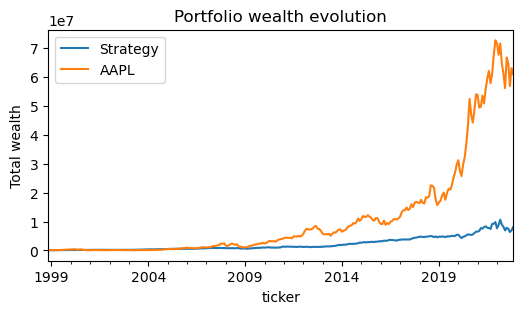

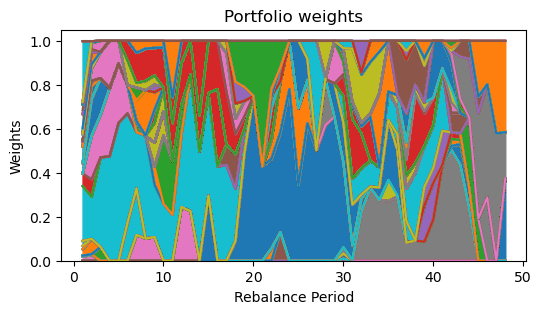

In [418]:
#--------------------------------------------------------------------------
# 3.2 Portfolio wealth evolution plot
#--------------------------------------------------------------------------
# Calculate the dates of the out-of-sample period

fig = plt.figure(1)
portfValue.iloc[:,:].plot(title = 'Portfolio wealth evolution',
                ylabel = 'Total wealth',
                figsize = (6, 3),
                legend = True)
plt.savefig("images/wealth.svg")

#--------------------------------------------------------------------------
# 3.3 Portfolio weights plot
#--------------------------------------------------------------------------
# Portfolio weights

fig2 = plt.figure(2);
x[x < 0] = 0
weights = pd.DataFrame(x, index = tickers)
weights.columns = [col + 1 for col in weights.columns]
if n <= 20:
    legend_bool = True
else:
    legend_bool = False
weights.T.plot.area(title = 'Portfolio weights',
                  ylabel = 'Weights', xlabel = 'Rebalance Period',
                  figsize = (6, 3),
                  legend = legend_bool, stacked = True)
if legend_bool:
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.savefig("images/weights_.svg");

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# % Program End

### 0.12% maximum absolute difference between the returns generated via Python and returns generated via MATLAB can be observed

### Terminal wealth between MATLAB and Python is within 0.1%

In [354]:
portfValue

,Strategy,AAPL
ticker,,
1998-11-30,100000.000000,100000.000000
1998-12-31,115426.870010,128177.833417
1999-01-31,113868.559819,128960.551002
1999-02-28,109926.802047,108985.597977
1999-03-31,115576.111205,112523.481519
1999-04-30,120346.453229,144020.037547
1999-05-31,121489.281169,137946.149020
1999-06-30,126883.165709,144990.607364
1999-07-31,127967.752803,174358.171527


In [57]:
8.796139e+05/392356.019899

2.2418769061487307

In [58]:
weights.loc[(weights > 0.001).any(axis = 1), :]

,1,2,3,4,5,6,7,8,9,10,...,20,21,22,23,24,25,26,27,28,29
AAPL,0.000000,0.000000,0.055845,0.068268,0.073434,0.081242,0.070991,0.074467,0.096864,0.0,...,0.000000,0.000000,0.0,0.000000,0.024864,0.029218,0.117806,0.112927,0.107906,0.113921
AEP,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.011597,0.011416,0.010637,0.000000,0.000000,0.000000,0.000000
AJG,0.000000,0.081883,0.067329,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
AMD,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.029593,0.009853,0.0,0.004378,0.070377,0.000000,0.159912,0.126164,0.141701,0.000000
ATO,0.082331,0.077912,0.072781,0.019870,0.016654,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WDC,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
WEC,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.037179,0.037896,0.039068,0.000000,0.000000,0.000000,0.000000
WST,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.026981,0.075329,0.208868,0.144889
X,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [60]:
(weights > 0.001).sum(axis = 0).max()

28

In [95]:
(np.abs(daily_adjClose.diff().dropna()) <= 0.001).sum().sort_values()

IWM      9
IJH     10
MDY     10
VBK     11
SPY     12
      ... 
DHF    696
CIF    704
BHV    710
MIN    710
NOM    823
Length: 299, dtype: int64

In [77]:
# Calculate the portfolio Sharpe ratio
ticker_rets = adjClose.pct_change(1).iloc[1:,]
ticker_rets = ticker_rets.loc[portfRets.index]

tickerExRets = ticker_rets.subtract(riskFree[(riskFree.index >= ticker_rets.index[0])&(riskFree.index <= ticker_rets.index[-1])], axis = 0)

tickerSR = ((tickerExRets + 1).apply(gmean, axis=0) - 1)/tickerExRets.std()

In [78]:
(12**0.5)*tickerSR.sort_values(ascending=False)

MIN    1.477841
AGG    1.051824
VBF    0.935671
MMT    0.921680
NIM    0.853253
         ...   
XLU   -0.915373
PEO   -0.930731
XLE   -0.946478
IYE   -0.948639
IDU   -0.959880
Length: 299, dtype: float64

In [125]:
(12**0.5)*tickerSR[ticker_str]

-0.3393755249273548

In [80]:
sum(Strategy.current_results['w'] > 0)

0